A ReAct agent is an AI agent that combines reasoning and action-taking to solve complex problems. It uses a framework that interleaves thinking (reasoning) with acting (using tools or APIs) to interact with the environment and achieve goals. 

In [1]:
import os 
 

# Read your API key from the environment variable or set it manually
api_key = os.getenv("GEMINI_API_KEY")

In [18]:
from typing import Annotated,Sequence, TypedDict

from langchain_core.messages import BaseMessage 
from langgraph.graph.message import add_messages # helper function to add messages to the state

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

In [25]:
from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests

geolocator = Nominatim(user_agent="weather-app")

class SearchInput(BaseModel):
    location: str = Field(description="The city and state, e.g., San Fransisco")
    date: str = Field(description="the forecasting date for when to get the weather format (yyy-mm-dd)")

@tool("get_weather_forecast", args_schema=SearchInput, return_direct=True)
def get_weather_forecast(location: str, date: str):
    """Retrieves the weather using Open-Meteo API for a given location (city) and a date (yyyy-mm-dd). Returns a list dictionary with the time and temperature for each hour."""
    location = geolocator.geocode(location)
    if location:
        try:
            response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={location.latitude}&longitude={location.longitude}&hourly=temperature_2m&start_date={date}&end_date={date}")
            data = response.json()
            return {time: temp for time, temp in zip(data["hourly"]["time"], data["hourly"]["temperature_2m"])}
        except Exception as e:
            return {"error": str(e)}
    else:
        return {"error": "Location not found"}

tools = [get_weather_forecast]

In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Create LLM class
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-pro-exp-03-25", # replace with "gemini-2.0-flash"
    temperature =1.0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    google_api_key=api_key
)

# Bind the tools to the model
model = llm.bind_tools([get_weather_forecast])

# Test the model with tools
model.invoke("What is the weather in Berlin on 12th of march 2025?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather_forecast', 'arguments': '{"date": "2025-03-12", "location": "Berlin"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro-exp-03-25', 'safety_ratings': []}, id='run-8331a8e7-40e4-442c-8f4e-420d87b8f2f7-0', tool_calls=[{'name': 'get_weather_forecast', 'args': {'date': '2025-03-12', 'location': 'Berlin'}, 'id': '0d5a76ab-3e1a-47f8-bb4e-429645475e83', 'type': 'tool_call'}], usage_metadata={'input_tokens': 134, 'output_tokens': 31, 'total_tokens': 338, 'input_token_details': {'cache_read': 0}})

In [27]:
# COmponents to build our agent, which we will assemble afterwards

import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
 
tools_by_name = {tool.name: tool for tool in tools}

# this is similar to customizing the create_react_agent with 'promp' parameter, but is more fleile
# system prompt = SystemMessage(
#   "You are a helpful assistant that use tools to access and retdrieve information from a wetaher api. Today is 2025-03-04. Help the user with their questions. Use the history to answer the question."
# )

# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # iterae over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
        state: AgentState,
        config: RunnableConfig
):
    # Invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the eisting messages state using the add_messages reducer
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue
    return "continue"

In [28]:
from langgraph.graph import StateGraph, END

# Define a new graph with our state
workflow = StateGraph(AgentState)

# 1. Add our nodes
workflow.add_node("llm", call_model)
workflow.add_node("tools", call_tool)
# 2. Set the entrypoints as 'agent', this is the first node called
workflow.set_entry_point("llm")
# 3. Add a conditional edge after the 'llm' node is called
workflow.add_conditional_edges(
    # Edge is used after the 'llm' node is called.
    "llm",
    # The function that will determine which node is called net.
    should_continue,
    # Mapping for where to go net, keys are strings form the function return, and the values are toher nodes.
    # END is a special node marking that the graph is finished.
    {
        # If 'tools', then we call the tool node
        "continue": "tools",
        "end": END,
    },
)
# 4. Add a normal edge after the 'tools' is called, 'llm' node is called net.
workflow.add_edge("tools", "llm")

# Now we can compile and visualize our graph
graph = workflow.compile()

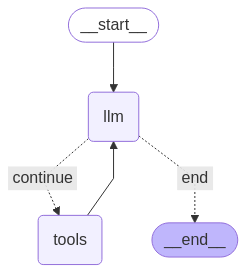

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
# Create our initial message dictionary
inputs = {"messages": [("user", "How is the weather in Berlin on 12th of March 2025?")]}

# call our graph with streaming to see the steps

for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

How is the weather in Berlin on 12th of March 2025?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (e20d069b-080f-4ecc-96e8-2fc0b2c4a7fc)
 Call ID: e20d069b-080f-4ecc-96e8-2fc0b2c4a7fc
  Args:
    date: 2025-03-12
    location: Berlin
================================= Tool Message =================================
Name: get_weather_forecast

{'2025-03-12T00:00': 4.5, '2025-03-12T01:00': 4.5, '2025-03-12T02:00': 4.8, '2025-03-12T03:00': 5.2, '2025-03-12T04:00': 5.2, '2025-03-12T05:00': 5.1, '2025-03-12T06:00': 5.0, '2025-03-12T07:00': 5.1, '2025-03-12T08:00': 5.6, '2025-03-12T09:00': 6.2, '2025-03-12T10:00': 7.0, '2025-03-12T11:00': 7.3, '2025-03-12T12:00': 7.5, '2025-03-12T13:00': 7.8, '2025-03-12T14:00': 8.2, '2025-03-12T15:00': 8.1, '2025-03-12T16:00': 7.9, '2025-03-12T17:00': 7.6, '2025-03-12T18:00': 7.1, '2025-03-12T19:00': 6.9, '202

In [30]:
state["messages"].append(("user", "Would it be in Munich warmer?"))

for state in graph.stream(state, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

Would it be in Munich warmer?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (80a74e4a-c4ad-4d03-a3b5-87849b2a448e)
 Call ID: 80a74e4a-c4ad-4d03-a3b5-87849b2a448e
  Args:
    date: 2025-03-12
    location: Munich
================================= Tool Message =================================
Name: get_weather_forecast

{'2025-03-12T00:00': 5.3, '2025-03-12T01:00': 5.0, '2025-03-12T02:00': 4.7, '2025-03-12T03:00': 3.8, '2025-03-12T04:00': 3.5, '2025-03-12T05:00': 3.4, '2025-03-12T06:00': 3.5, '2025-03-12T07:00': 4.5, '2025-03-12T08:00': 4.9, '2025-03-12T09:00': 5.7, '2025-03-12T10:00': 6.6, '2025-03-12T11:00': 8.0, '2025-03-12T12:00': 9.2, '2025-03-12T13:00': 10.1, '2025-03-12T14:00': 10.6, '2025-03-12T15:00': 9.9, '2025-03-12T16:00': 9.6, '2025-03-12T17:00': 9.3, '2025-03-12T18:00': 8.9, '2025-03-12T19:00': 8.2, '2025-03-12T20:00': 7.5,